## **Problem description**
***
The problem in this project is trying to figure out if a
user’s tweet indicates if a disaster is taking place
somewhere or not. For a human, it can be very easy to
distinguish the difference. However, for the machine it can
be a quite problem. For example, the word “fire” can
indicate a disaster somewhere but if we see a such tweet:
“Last night party was fire.” we easily can recognize that
there were no disaster at all because we learned overtime
that in the American English the word can be used in that
positive way. Thus, the task is to let the machine somehow
learn such difference and **predict efficiently the nature of
the tweet either disastrous or not**. Obliviously, it is a
**binary classification problem**.

## **Goal**
***

Given a sample of labeled tweets with disastrous or non
disastrous labels, it is required to build a machine learning
model that can learn and differentiate between the two
labels and p**redict the correct label for any new tweet with
the highest possible accuracy, recall and F score.**

## **Workflow**

I need to follow the following steps so that I can build the model.

**Data prepration**:

In this phase I load the data, check the missings, duplicates, check featuers and choose which featuers from the raw data to include in my models.

**Preprocessing**:

Prepeocessing is where 

Build models

Evaluate models

Tune hyperparameters

Choose best model

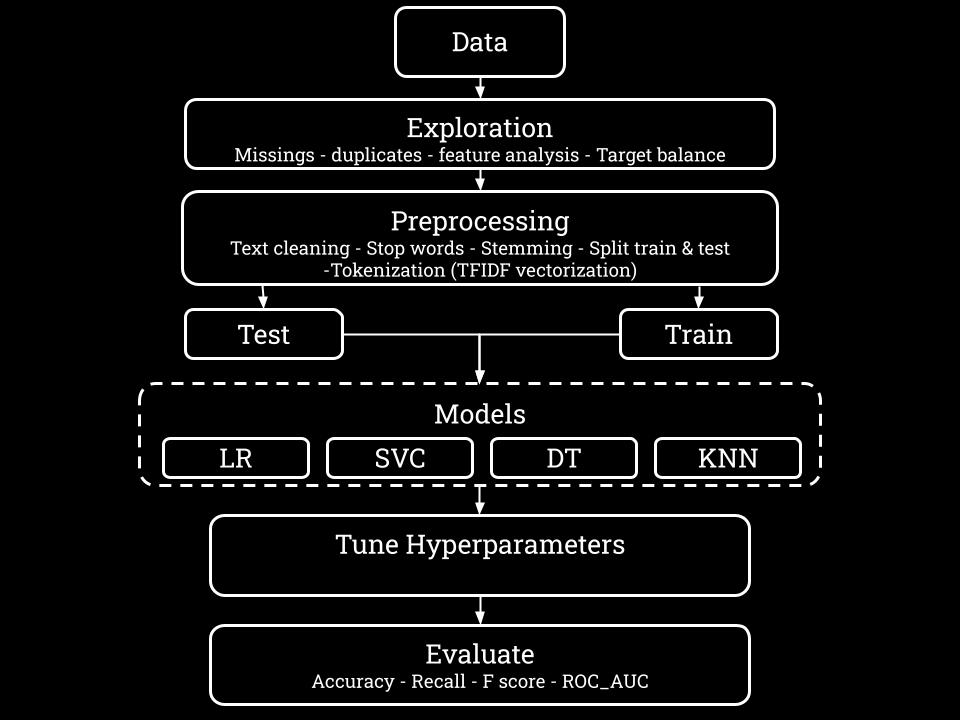


# 1. **Loading data**
***

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [74]:
train = pd.read_csv("../input/nlp-getting-started/train.csv", sep=",") 
test = pd.read_csv('../input/nlp-getting-started/test.csv', sep=",")

perfect_submission = pd.read_csv(
    "https://raw.githubusercontent.com/mitramir55/Kaggle_NLP_competition/master/perfect_submission.csv"
    , sep=",") # provides the correct targets for test set

test["target"] = perfect_submission["target"]

test.head()

The data is already split into test and train sets. Data
size is **10876 records** in total; **7613** in the **training** set and
**3263** in the **testing** set. Train and test sets contain these

**columns**:
*  **id**:- a unique identifier for each tweet.
*  **text**:- the text of the tweet.
*  **location**:- the tweet location (may be blank).
*  **keyword**:- tweet search keyword (may be blank).
*  **target**:- in train.csv only1, tweet label disaster (1) or not (0).

* Append test to train for overall dataset analysis. it will be randomly split later before building the models

In [75]:
data = train.append(test)
data

# 2. **Data Exploration**
***

## 2.1 Data size

In [76]:
print('Total length of the dataset: ', len(data))

## 2.2 **Missing values**

In [77]:
null_values= pd.DataFrame(np.c_[data.isnull().sum(), (data.isnull().sum()/ len(data))],
                     columns = ['number of nulls', 'percentage of nulls'],
                     index = data.columns)
null_values.plot.bar( y='percentage of nulls',rot= 0)
null_values

**Notes:**
- **No missing** values in **Id**, **text** and **target** columns.
- **33%** of **location** values are **messing**. 
- **0.007%** values are **missing** in **keywords**.

Then, we will drop **location**.

In [78]:
data= data.drop('location', axis=1)
data.head(5)

## 2.3 **keyword** feature analysis

We need to check **if keyword already exists in the tweet text**


In [79]:
key_word_in_tweet = data.apply(lambda x: True if 
                               x["keyword"] in x["text"].lower().split() else False,
                               axis=1 )
key_word_in_tweet= (key_word_in_tweet.value_counts(normalize=True)*100).to_frame( name="keyword_in_tweet_%").transpose()

key_word_in_tweet.plot.bar(rot=0)
key_word_in_tweet

almost **62%** of **keywords** already **exist** in the text.

* **We can add the keywords to text in case it does not exist in text.**
* Then we can drop **keyword** and **id**.

In [80]:
data["text"]= data.apply(lambda x: x["keyword"].lower()+ " " + x["text"].lower() if
                         ((not pd.isnull(x["keyword"])) and (x["keyword"].lower() not in x["text"].lower().split())) else  x["text"],
                         axis=1 )

In [81]:
data.tail(300).head(5)

In [82]:
data = data.drop(['keyword', "id"], axis=1)
data.head(5)

## 2.4 **Duplicates**

In [83]:
print(len(data)-len( data.drop_duplicates()))
data= data.drop_duplicates()

**138 duplicate recordes were deleted**

## 2.5 Check **target** balance


In [84]:
target_balance= (data["target"].value_counts(normalize=True)*100).to_frame( name="class_count_%").transpose()
target_balance.plot.bar( rot=0)

**Target** balance is almost **40%(1)** to **60%(0)**. we can use the **class weight attribute** in the models to overcome the slight imbalance in the data.

# 3. **Preprocessing**
***

First I need to **clean the tweets' text**. Then perform the **words tokenization**.

## 3.1 **Clean tweets' text**

Here I clean the text of each tweet to be ready for tokenization process.

* Remove links
* Convert mentions to a word token
* Convert retweets to a word token
* Convert hashtags to a word token
* Convert numeric values to a word token
* Convert punctuations to a word token
* Remove any nonalphabatical charactar (punctuation, symbols, numbers,....)
* Remove stop words
* Apply stemming on every word

In [85]:
# cleaning tweet text

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import nltk

ls = nltk.LancasterStemmer()

def clean_tweet(tweet):

    temp = tweet.lower()
    temp = re.sub(r'http\S+', '', temp)                       # remove links
    temp = re.sub(r'@', ' featurementions ', temp)            # convert mentions to a word token
    temp = re.sub(r' rt ', ' featureretweet ', temp)          # convert retweets to a word token
    temp = re.sub(r'#', ' featurehashtags ', temp)            # convert hashtags to a word token
    temp = re.sub(r'[0-9]+', ' featurenumeric ', temp)        # convert numeric values to a word token
    temp = re.sub(r'[!.:;_,?]+', ' featurepunc ', temp)       # convert punctuations to a word token
    temp = re.sub("[^a-z]"," ", temp)                         # remove any nonalphabatical charactar (punctuation, symbols, numbers,....)
    temp = temp.split()
    temp = [w for w in temp if not w in ENGLISH_STOP_WORDS]   # remove stop words
    temp = [ls.stem(w) for w in temp if  w != ""]             # apply stemming on every word
    temp = " ".join(word for word in temp)
 
    return temp

**Tweets after cleaning**

In [86]:
data["text"] = data["text"].apply(clean_tweet)
data.head()

## 3.2 **Split data into Train and Test sets**

In [87]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.3)
test.tail()

## 3.2 **Tokenization**

For Tokenization I used **Tfidf** vectorizer as it performes beter than the **Counter**

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

x_train = train["text"]
x_test = test["text"]
y_train = train["target"]
y_test = test["target"]

vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.9999)
vectors = vectorizer.fit_transform(list(x_train) + list(x_test))

x_train_vec = vectorizer.transform(x_train)

x_test_vec = vectorizer.transform(x_test)


# showing how tokens looklike
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head(5)

Now each word in each record has it's own **Tfidf score** and with that the data is ready for modeling

# 4. **Models**
***

First, I'll import sklearn metrics that I will use to evaluate my models.

**Accuarcy** is very important metric. yet, for such **binary classification problem**. I need to take care of **Recall**, **F score** , **Confusion matrix** and  **Roc_auc**

That's because I need to minimize the **type II** Error which is represented in **the number of False positives**

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

I'll define a function to run my different models through it. 

The function will

1. Recieve the chosen model.
2. Fit the training data.
3. predict the targets for test set
4. show the required metrics in text and plots

In [90]:
def model(my_model , name):
    
    # fit the model with data
    my_model.fit(x_train_vec,y_train)

    # perform classification and prediction on samples in x_test_vec
    y_pred=my_model.predict(x_test_vec)

    print(f"{name} Accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"{name} Recall score: {recall_score(y_test, y_pred)}")
    print(f"{name} F1 score: {f1_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


    #plots
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    cm = confusion_matrix(y_test, y_pred, labels=my_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=my_model.classes_)
    disp.plot(ax=ax1)


    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

    display.plot(ax=ax2)

    plt.show()

## 4.1 **Logistic Regression**

In [91]:
from sklearn.linear_model import LogisticRegression


# Instantiate the model
LR =  LogisticRegression(class_weight='balanced', max_iter=1000)

# Run the model
model(LR, "Logistic Regression")

## **Tuning Logistic Regression Hyperparameters**

I'm using **GridSearchCV** to perform the cross validation to tune the parameters as following:

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [   
    {
    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "max_iter": [1000],
    "penalty": ["l2"],
    'C': np.arange(0.1, 2, 0.1)
    }
]

LR_clf_cv = GridSearchCV(LR, param_grid = param_grid, refit=True, cv = 20 , verbose=True , n_jobs=-1, scoring="roc_auc")
best_LR_clf = LR_clf_cv.fit(x_train_vec,y_train)

best_LR_clf.best_estimator_

In [21]:
LR =  LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000, C=1.4000000000000001)

model(LR, "Logistic Regression")

We can notice slight enhancement after the tuning in accuracy and recall and F score.

## 4.2 **SVC**

In [45]:
from sklearn import svm

# classify using support vector classifier
svc = svm.SVC(class_weight='balanced')

model(svc, "SVC")

We can see that **SVM** performed more or less like Logistic Regression. but it has quite **less recall** and  we can see **the number of False positives is higher**.

However, we need to check how it will perform with tuning it's hyperparameters **C** and **gamma**

## **Tuning SVC Hyperparameters**

In [23]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [ 0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly']
             }

svc_clf_cv = GridSearchCV(svc, param_grid = param_grid, cv = 5, refit = True, verbose=True, n_jobs=-1, scoring="roc_auc")

best_svc_clf= svc_clf_cv.fit(x_train_vec, y_train)

print(best_svc_clf.best_params_)

In [24]:
svc = svm.SVC(class_weight='balanced', C=1, gamma = 1, kernel = 'rbf')

model(svc, "SVC")

Clearly, there is **no change in the evaluation metrics** after the tuning.

## 4.3 **Decision Trees**

In [25]:
from sklearn.tree import DecisionTreeClassifier


DT = DecisionTreeClassifier(class_weight='balanced')

model(DT, "Decision Tree")

Decision trees had **quite less values for all the evaluation metrics**.

## **Tuning Decision trees Hyperparameters**

In [26]:
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth':  list(range(95, 120, 1))
             }

DT_clf_cv = GridSearchCV(DT, param_grid = param_grid, cv = 10, refit = True, verbose=True, n_jobs=-1, scoring="roc_auc")

best_DT_clf= DT_clf_cv.fit(x_train_vec, y_train)

print(best_DT_clf.best_params_)

In [27]:

DT = DecisionTreeClassifier(class_weight='balanced',criterion= 'entropy', max_depth = 103 )

model(DT, "Decision Tree")

There is little **improvment in accuracy** but **worse recall and F score**

## 4.4 **K-Nearest Neighbors Classifier**

In [102]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=5)

model(KNN, "KNN")

**MLP** **accuracy** is **better than SVC and Decision trees**.However **not better than Logistic Regression**.

While the **Recall is the closest to LR** out of the 3 models **yet LR still have better Recall**.

## **Tuning K-Nearest Neighbors Hyperparameters**

In [104]:
param_grid = { 'leaf_size' : list(range(1,50)),
               "n_neighbors" : list(range(90,100)),
               "p":[1,2]
             }

KNN_clf_cv = GridSearchCV(KNN, param_grid = param_grid, cv = 5, refit = True, verbose=True, n_jobs=-1, scoring="roc_auc")

best_KNN_clf= KNN_clf_cv.fit(x_train_vec, y_train)

print(best_KNN_clf.best_params_)

In [105]:
KNN = KNeighborsClassifier(n_neighbors=90, leaf_size=1, p=2)

model(KNN, "KNN")

# 5. **Summary**

we can now compare all the models after tuning and choose best one.

**The best model shall be chosen based on best F score and Recall as that minimizes the false positives as the problem requires**

| Model                    | Accuracy            |        Recall  |  F score   | 
|--------------------------|:-------------------:|---------------:|-----------:|
| **Logistic Regression**      |         **0.80**        |   **0.744**      | **0.765**      |
| SVC                      |         0.80        |    0.704       | 0.754     | 
| Decision trees           |         0.73        |     0.627      | 0.673  |
| KNN                      |         0.76     |    0.642    | 0.70  | 

Hence, **Logistic Regression** is the best model with** accuracy** of **80%** and **F score** of **76.5%**